In [1]:
from gensim.models.keyedvectors import KeyedVectors
import numpy as np
import pylab as plt
from nltk.corpus import words
import pandas as pd
import sys
from scipy import spatial, stats
from collections import Counter, defaultdict
from matplotlib.colors import ListedColormap
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.cm as cm
from numpy import dot
from numpy.linalg import norm
import operator
from statistics import mean, stdev
from scipy.stats import pearsonr, spearmanr  
import math
from sklearn.preprocessing import PolynomialFeatures 
from sklearn.linear_model import LinearRegression
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import json
import networkx as nx
import copy
import pickle
import matplotlib.colors
from stargazer.stargazer import Stargazer, LineLocation
import time
#from linearmodels.panel import PanelOLS

# flush print
def flushPrint(d):
    sys.stdout.write('\r')
    #sys.stdout.write(str(d))
    sys.stdout.write('%d' % d)
    sys.stdout.flush()

def OLSRegressFit(x,y):
    xx = sm.add_constant(x, prepend=True)
    res = sm.OLS(y,xx).fit()
    constant, beta = res.params
    r2 = res.rsquared
    return [constant, beta, r2]

# calculate CI using bootstrap
def calculateCI2(data,method,n, k):
    m=int(len(data)*k) #take 10% data
    ms=[]
    for j in range(n): #number of samples
        if method=='mean':
                ms.append(np.mean(np.random.choice(data,m)))
        if method=='median':
                ms.append(np.median(np.random.choice(data,m)))
    a,b=[np.percentile(ms,2.5),np.percentile(ms,97.5)]
    
    return (b-a)/2

C:\Users\ditong\Anaconda3\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


### Data

In [193]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

In [362]:
# JOB YEAR NPOSTS Medianpay Mineducation
jyn = defaultdict(lambda:defaultdict(lambda:0))
yjn = defaultdict(lambda:defaultdict(lambda:0))
jye = defaultdict(lambda:defaultdict(lambda:0))
yje = defaultdict(lambda:defaultdict(lambda:0))
jyp = defaultdict(lambda:defaultdict(lambda:0))
yjp = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/year_socName_Nposts_aveMedianPay_aveMinEdu.txt',
          'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        year = int(line_lst[0])
        job = line_lst[1]
        num = int(line_lst[2])
        edu = line_lst[3]
        pay = line_lst[4]
        if year != 2019:
            jyn[job][year] = num
            yjn[year][job] = num
            if edu != 'nan' and edu != 'nan\n': 
                if float(edu) > 0:
                    jye[job][year] = float(edu)
                    yje[year][job.lower()] = float(edu)
            if pay != 'nan' and pay != 'nan\n':
                if float(pay) > 0:
                    jyp[job][year] = float(pay)
                    yjp[year][job] = float(pay)

In [363]:
# soc - pay - education
oe={}
op={}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/socName_aveMedianPay_aveMinEdu_socGroup.txt','r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        job = line_lst[0]
        op[job] = float(line_lst[1])
        oe[job] = float(line_lst[2])

In [364]:
# JOB-SKILL DATA
# without filtering the skills
yjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year == 2010 or year==2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    yjas[year][job][skill] = tfidf
                    
# job - top 5% defining skills
jys = defaultdict(lambda:defaultdict(lambda:[]))
syj = defaultdict(lambda:defaultdict(lambda:[]))
for year in yjas:
    for job in yjas[year]:
        threshold = np.quantile(list(yjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        for skill in yjas[year][job]:
            if yjas[year][job][skill] > threshold:
                jys[job][year].append(skill)
                syj[skill][year].append(job)
        if len(jys[job][year]) < 5:
            #print(job, year)
            del jys[job][year]
            fulllist = syj[skill][year]
            syj[skill][year] = [value for value in fulllist if value != job]
            
# job - SKILL NUMBER
osn = {}
for job in jys:
    snlst = []
    for yr in jys[job]:
        if len(jys[job][yr]) != 0:
            snlst.append(len(jys[job][yr]))
    if snlst:
        osn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
osn = dict(sorted(osn.items(), key=operator.itemgetter(1),reverse=True))

In [261]:
# job vector
# 200 dimension Job-Year-Vector
yjv = defaultdict(lambda:defaultdict(lambda:''))
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        yjv[y][j] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        #jyv[j][y] = np.sum([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)
        
# job stability from 2010 to 2018: dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

### Extended Methods: Replication of Deming and Noray's (2020) Job Skill Change Measurement

In [57]:
# read in saved data
occ_y_skill_freq = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
occ_y_sfreq = defaultdict(lambda:defaultdict(lambda:0))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq_emp.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        occ = linelst[0]
        year = linelst[1]
        sfreqs = linelst[2:]
        for s in sfreqs:
            sk = s.split("_")[0]
            freq = int(s.split("_")[1])
            occ_y_skill_freq[occ][year][sk] = freq
            occ_y_sfreq[occ][year] += freq
            
occ_y_freq = defaultdict(lambda:defaultdict(lambda:0))            
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_npost_emp.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        occ = linelst[0]
        year = linelst[1]
        freq = int(linelst[2])
        occ_y_freq[occ][year] = freq

In [62]:
# calculate job skill change and save data
# weights
jw1 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2010' in occ_y_sfreq[j] and '2018' in occ_y_sfreq[j]:
            jw1[j] = (occ_y_sfreq[j]['2010'] / occ_y_sfreq[j]['2018']) / (occ_y_freq[j]['2010']/occ_y_freq[j]['2018'])
            if jw1[j] > 1:
                jw1[j] = 1
                
jw2 = {}
for j in occ_y_sfreq:
    if j in occ_y_freq:
        if '2007' in occ_y_sfreq[j] and '2019' in occ_y_sfreq[j]:
            jw2[j] = (occ_y_sfreq[j]['2007'] / occ_y_sfreq[j]['2019']) / (occ_y_freq[j]['2007']/occ_y_freq[j]['2019'])
            if jw2[j] > 1:
                jw2[j] = 1
                
# skill probability
jyspro = copy.deepcopy(occ_y_skill_freq)
for j in jyspro:
    for y in jyspro[j]:
        for s in jyspro[j][y].keys():
            jyspro[j][y][s] = jyspro[j][y][s]/occ_y_freq[j][y]
            
# job change
jyc = defaultdict(lambda:defaultdict(lambda:0))
occsc79=defaultdict(lambda:0)
occsc80=defaultdict(lambda:0)
for j in jyspro:
    if '2007' in jyspro[j] and '2019' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2007'].keys()).union(set(jyspro[j]['2019'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['07-19'] += abs(jyspro[j]['2019'][s] - jyspro[j]['2007'][s])
        jyc[j]['07-19'] = jyc[j]['07-19']*jw2[j]
        occsc79[j] = jyc[j]['07-19']
            
    if '2010' in jyspro[j] and '2018' in jyspro[j]:
        # get the union of skills of 2 years
        alls = set(jyspro[j]['2010'].keys()).union(set(jyspro[j]['2018'].keys()))
        # skill probability change
        for s in alls:
            jyc[j]['10-18'] += abs(jyspro[j]['2018'][s] - jyspro[j]['2010'][s])
        jyc[j]['10-18'] = jyc[j]['10-18']*jw1[j]
        occsc80[j] = jyc[j]['10-18']
        
# save 
df79 = pd.DataFrame()
sorted79 =  dict(sorted(occsc79.items(), key=operator.itemgetter(1), reverse=True))
df79['SOC'] = list(sorted79.keys())
df79["SkillChange"] = list(sorted79.values())
df79.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/0719Soc6SkillChange_emp.csv')

df80 = pd.DataFrame()
sorted80 =  dict(sorted(occsc80.items(), key=operator.itemgetter(1), reverse=True))
df80['SOC'] = list(sorted80.keys())
df80["SkillChange"] = list(sorted80.values())
df80.to_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/1018Soc6SkillChange_emp.csv')

In [3]:
# data in Deming and Noray (2020) appendix
OriData = pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/QJE_SOC6Change.xlsx')
SOCR = {}
for i, j in zip(OriData["occupation_title"], OriData["RATE"]):
    SOCR[str(i)] = j

# replication
ReplData = pd.read_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/0719Soc6SkillChange_emp.csv')
re = {}
for i, j in zip(ReplData['SOC'], ReplData["SkillChange"]):
    re[str(i)] = j

# calculate correlation
#re = occsc79    
repl = {}
for j in SOCR:
    if j in re:
        repl[j] = (SOCR[j],re[j])

x,y = zip(*list(repl.values()))
print(pearsonr(x,y))
# fig = plt.figure(figsize=(5,5))
# ax1 = fig.add_subplot(111)
# plt.scatter(x,y, label="r=0.87***")
# plt.title("Job Skill Change Replication, 2007-19", fontsize=16)
# plt.xlabel("Original Measure, 2007-19", fontsize=16)
# plt.ylabel("Replicated Measure, 2007-19", fontsize=16)
# plt.legend(fontsize=18)

(0.8696114554674294, 2.0059318581748458e-88)


### Extended Methods: Cluster Approach to Measure Occupational Skill Change

In [66]:
# skill--community
partition = defaultdict(lambda:[])
sp = {}
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/partition_0.0_0.0_6_0.51.txt','r') as f:
    for line in f:
        skill = line.split('\t')[0]
        group = int(line.split('\t')[1])
        partition[group].append(skill)
        sp[skill] = group

# community labels
labels = ['business and managerial skills', 'engineering, technical, and manual skills', 
          'computer and programming skills', 'clerical and analytical skills', 
          'scientific and research skills', 'medical and health skills']

In [69]:
# job - skill community - frequency
jyscf = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for job in jys:
    for year in jys[job]:
        for s in jys[job][year]:
            if s in sp:
                jyscf[job][year][sp[s]] += 1
        #yjscf[year][job] = dict(sorted(yjscf[year][job].items(), key=operator.itemgetter(1), reverse=True))

# job - skill community - share change
occ_scc = defaultdict(lambda:0)
for occ in jyscf:
    if 2010 in jyscf[occ] and 2018 in jyscf[occ]:
        skills = set(jyscf[occ][2010].keys()).union(jyscf[occ][2018].keys())
        for skill in skills:   
            occ_scc[occ] += abs(jyscf[occ][2018][skill]/sum(jyscf[occ][2018].values()) - 
                          jyscf[occ][2010][skill]/sum(jyscf[occ][2010].values())) 
# sort the occupation by skill change
sorted_occscc = dict(sorted(occ_scc.items(), key=operator.itemgetter(1), reverse=True))

In [70]:
# skill cluster share change for two occupations
# computer programmers
# skill cluster freq for each year
fil_pc10 = defaultdict(lambda:0)
for k in jys["Computer Programmers"][2010]:
    if k in sp:
        fil_pc10[sp[k]] += 1
fil_pc18 = defaultdict(lambda:0)
for k in jys["Computer Programmers"][2018]:
    if k in sp:
        fil_pc18[sp[k]] += 1
allcc = set(fil_pc10.keys()).union(fil_pc18.keys())
# skill cluster share change
sdiffCC = {}
for k in allcc:
    sdiffCC[k] = abs(fil_pc18[k]/sum(fil_pc18.values()) - fil_pc10[k]/sum(fil_pc10.values()))

# Food Batchmakers
fil_pb10 = defaultdict(lambda:0)
for k in jys['Food Batchmakers'][2010]:
    if k in sp:
        fil_pb10[sp[k]] += 1
fil_pb18 = defaultdict(lambda:0)
for k in jys['Food Batchmakers'][2018]:
    if k in sp:
        fil_pb18[sp[k]] += 1
allbc = set(fil_pb10.keys()).union(fil_pb18.keys())

sdiffBC = {}
for k in allbc:
    sdiffBC[k] = abs(fil_pb18[k]/sum(fil_pb18.values()) - fil_pb10[k]/sum(fil_pb10.values()))

In [73]:
# 200 dimension Job-Year-Vector
jyv = defaultdict(lambda:defaultdict(lambda:''))
for j in jys:
    for y in jys[j]:
        jyv[j][y] = np.mean([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

# job change from 2010 to 2018: 1 - dot product between 2 job vectors
jtr = {}
for j in jyv:
    if 2010 in jyv[j] and 2018 in jyv[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr[j] = 1- np.dot(jyv[j][2018], jyv[j][2010])/(np.linalg.norm(jyv[j][2018])* np.linalg.norm(jyv[j][2010]))

jtr = dict(sorted(jtr.items(), key=operator.itemgetter(1)))

In [71]:
occ_scc['Computer Programmers'], occ_scc["Food Batchmakers"]

(0.19677965685672907, 0.3553921568627451)

(0.7618382894447562, 7.380695063066697e-139)


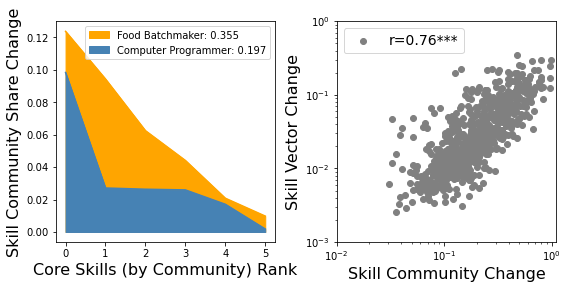

In [74]:
fig = plt.figure(figsize=(8,4))
ax2 = fig.add_subplot(121)
sb = sorted(sdiffBC.values(), reverse=True)
plt.plot(sb, color="orange")
plt.fill_between(range(len(sb)),sb,0,color="orange", label="Food Batchmaker: 0.355")
sc=sorted(sdiffCC.values(), reverse=True)
plt.plot(sc, color="steelblue")
plt.fill_between(range(len(sc)),sc,0,color="steelblue", label="Computer Programmer: 0.197")
plt.legend(fontsize=10)
plt.ylabel("Skill Community Share Change", fontsize=16)
plt.xlabel("Core Skills (by Community) Rank", fontsize=16)        


ax2 = fig.add_subplot(122)
scc_vec = {}
for j in sorted_occscc:
    if j in jtr:
        scc_vec[j] = (sorted_occscc[j],jtr[j])
x,y = zip(*list(scc_vec.values()))
print(pearsonr(np.log(x),np.log(y)))
plt.scatter(x,y, label="r=0.76***", color="grey")

# x=np.array(x).reshape(-1, 1)
# y=np.array(y).reshape(-1, 1)
# poly = PolynomialFeatures(degree = 1) 
# X_poly = poly.fit_transform(x) 
# poly.fit(X_poly, y) 
# lin2 = LinearRegression() 
# lin2.fit(X_poly, y) 
# xnew = np.linspace(0,3,100).reshape(-1, 1)
# plt.plot(xnew, lin2.predict(poly.fit_transform(xnew)), color = '#a9cbd2', linewidth=5)

plt.xlabel("Skill Community Change", fontsize=16)
plt.ylabel("Skill Vector Change", fontsize=16)
plt.legend(loc=2, fontsize=14)

plt.ylim(1/1000,1)
plt.xlim(1/100,1.1)
plt.yscale("log")
plt.xscale("log")
plt.tight_layout()
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/SI/SI_ClusterVector.pdf') 

### Extended Method: Identify Re-skilling Directions with Skill Atoms

In [330]:
# all data, 200 dimensions, 300 window, skipgram, negative sampling 5, word occurence > 10
model = Word2Vec.load("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/w2v_m10_s200_w300_sg1_n5.model")

In [340]:
infile = open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_dictionary_nvdrsdf20','rb')
dictionary=pickle.load(infile)
infile.close()

infile = open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_aksvd_nvdrsdf20','rb')
aksvd=pickle.load(infile)
infile.close()

infile = open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_model/200d_210comp5nonzeros_alpha_nvdrsdf20','rb')
alpha=pickle.load(infile)
infile.close()

In [343]:
# job-year-array of weights
allskills=list(model.wv.index_to_key)
jyw=defaultdict(lambda:defaultdict(lambda:np.array([])))
for job in jys:
    if 2010 in jys[job] and 2018 in jys[job]:
        aw = np.zeros(shape=(1,210))
        for s in jys[job][2010]:
            if s in allskills:
                aw = aw + np.array(alpha[model.wv.key_to_index[s]])
        jyw[job][2010] = aw[0] / sum(aw[0])
        for s in jys[job][2018]:
            if s in allskills:
                aw = aw + np.array(alpha[model.wv.key_to_index[s]])
        jyw[job][2018] = aw[0] / sum(aw[0])  

In [344]:
# job-year-atom-weight
jyaw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
yajw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for job in jyw:
    for year in jyw[job]:
        order = np.argsort(jyw[job][year])[::-1]
        for ind in order:
            jyaw[job][year][ind] = jyw[job][year][ind]
            yajw[year][ind][job] = jyw[job][year][ind]

In [345]:
# job-atom weight change
jawd = defaultdict(lambda:defaultdict(lambda:0))
ajwd = defaultdict(lambda:defaultdict(lambda:0))
for job in jyw:
    diff = jyw[job][2018] - jyw[job][2010]
    order = np.argsort(diff)[::-1]
    for ind in order:
        idiff = jyw[job][2018][ind] - jyw[job][2010][ind]
        jawd[job][ind] = idiff
        ajwd[ind][job] = idiff

In [346]:
ad = {}
for a in ajwd:
    ad[a] = sum(ajwd[a].values())
ad = dict(sorted(ad.items(), key=lambda item: item[1], reverse=True))

In [347]:
# obstain 2D coordinates by embedding 
coordsTSNE = TSNE(n_components=2, random_state=0).fit_transform(dictionary)

# skill-2D vector
atv={}
for i in range(210):
    atv[i] = coordsTSNE[i]

In [348]:
# read in 2d locations
atv={}
with open ("/Users/ditong/Dropbox (MIT)/skills/Data/intermediate/atom_2dloc.txt", 'r') as f:
    for line in f:
        line_lst=line.split("\t")
        atv[int(line_lst[0])] = (float(line_lst[1]), float(line_lst[2]))

In [349]:
# read in labels: machine/human
atlabel = pd.read_csv("/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/atom_labeling.csv")
cola = {}
cola['cornflowerblue'] = 'machine'
cola['orange'] = 'human'

acol = {}
for i, row in atlabel.iterrows():
    if row['machine'] == 0: #or row['machine'] == 2:
        acol[row['index']] = 'orange'
    else:
        acol[row['index']] = 'cornflowerblue'

In [350]:
len(atv), len(acol)

(210, 210)

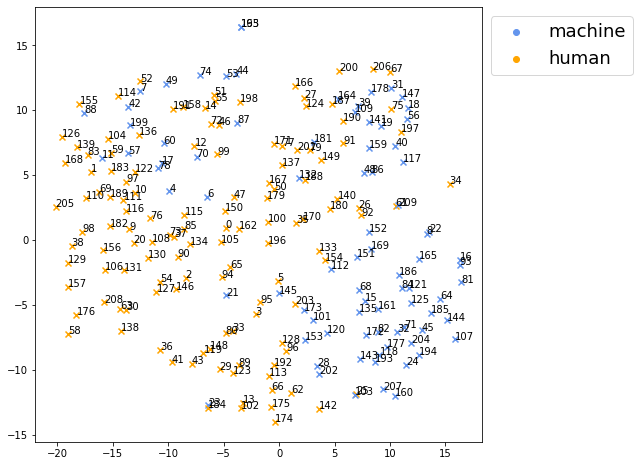

In [351]:
# original 2d positions
fig = plt.figure(figsize=(8, 8),facecolor='white')
ax = fig.add_subplot(111)
for at in atv:
    x,y = atv[at]
    plt.scatter(x,y,color=acol[at],marker='x')
    plt.annotate(str(at), (x, y))
            
for col in cola:
    plt.scatter([],[], color=col, label=cola[col])
plt.legend(bbox_to_anchor=(1.0, 1.0), fontsize=18)

In [352]:
# get the boundaries of all locations
xl=50
xr=-50
yu=-50
yd=50
for a in atv:
    x,y=atv[a]
    if x<xl:
        xl=x
    if x>xr:
        xr=x
    if y<yd:
        yd=y
    if y>yu:
        yu=y

xl,xr,yu,yd

(-20.169127, 16.451687, 16.429686, -14.035293)

In [353]:
# set up gridspace
gridx=np.linspace(xl, xr, num=15)
gridy=np.linspace(yd, yu, num=14)
gridloc=[]
for x in gridx:
    for y in gridy:
        gridloc.append((x,y))
len(gridx), len(gridy), len(gridloc)

(15, 14, 210)

In [354]:
# calculate the distance from each atom to each grid node
agdis = defaultdict(lambda:defaultdict(lambda:0))
for a in atv:
    for loc in gridloc:
        agdis[a][loc]=math.sqrt((loc[0]-atv[a][0])**2+(loc[1]-atv[a][1])**2)

In [355]:
# for each grid node, assign nearest atom to it
agdis2=copy.deepcopy(agdis)
locadis={}
aloc={}
for loc in gridloc:
    dis=10000
    at=''
    for a in agdis2:
        if agdis2[a][loc] < dis:
            dis = agdis2[a][loc]
            at=a
    locadis[loc]=(at, dis)
    aloc[at]=loc
    if at != '':
        del(agdis2[at])

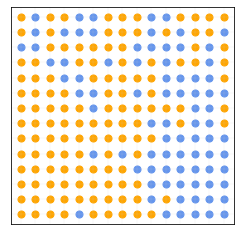

In [356]:
fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    if locadis[loc][0] != '':
        plt.scatter(loc[0], loc[1], color=acol[locadis[loc][0]], s=50)
#plt.title("Skill Atoms",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)
#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P1.pdf') 

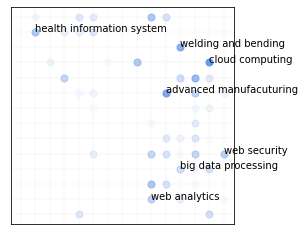

In [359]:
# rising machine atoms

gi2={}
gi2[121]="cloud computing"
gi2[48]="advanced manufacuturing"
gi2[18]='welding and bending'
gi2[82]='big data processing'
gi2[202]='web analytics'
gi2[7]='health information system'
gi2[15]='web security'

fig = plt.figure(figsize=(4, 4),facecolor='white')

ax = fig.add_subplot(111)
k=1
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp>0 and acol[at]=='cornflowerblue':
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(alp*k,1), s=50)
        if at in gi2 and acol[at]=='cornflowerblue':
            plt.text(loc[0], loc[1], gi2[at], fontsize=10)
#         elif acol[at]=='cornflowerblue':
#             plt.text(loc[0], loc[1], str(at), fontsize=10)
#plt.title("Rising Skill Atoms",fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P3_v2.pdf')

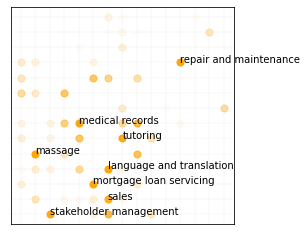

In [360]:
# declining human atoms

di={}
di[73]='medical records'
di[156]="massage"
di[89]='mortgage loan servicing'
di[75]="repair and maintenance"
di[3]="language and translation"
di[5]="tutoring"
di[36]="stakeholder management"
di[113]="sales"
#di[13]="investment and assest"
#di[105]="hospitality industry knowledge"

fig = plt.figure(figsize=(4, 4),facecolor='white')
k=1
ax = fig.add_subplot(111)
for x in gridx:
    plt.axvline(x=x, color='lightgrey',alpha=0.1)
for y in gridy:
    plt.axhline(y=y, color='lightgrey',alpha=0.1)
for loc in locadis:
    at=locadis[loc][0]
    if at != '':
        alp=ad[at]
        if alp<0 and acol[at]=="orange":
            plt.scatter(loc[0], loc[1], color=acol[at], alpha= min(abs(alp*k),1),s=50)
        if at in di and acol[at]=="orange":
            plt.text(loc[0], loc[1], di[at], fontsize=10)
#plt.title("Decling Skill Atoms", fontsize=14)
ax.axes.get_xaxis().set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/Fig2/Fig2P4_v2.pdf')

### Extended Data: Representativeness of Job Ads Data Collected by Burning Glass Technologies

In [7]:
# BLS Education
df_2018e=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/education.xlsx', 
                      sheet_name="Assignment", header=1)

eduy = []
for i in df_2018e['Typical education needed for entry']:
    if pd.isnull(i) == True:
        eduy.append('nan')
    elif i == 'No formal educational credential':
        eduy.append(0)
    elif i =='High school diploma or equivalent':
        eduy.append(12)  
    elif i in ['High school diploma or equivalent','Some college, no degree','Postsecondary nondegree award']:
        eduy.append(12)
#     elif i in ['Some college, no degree','Postsecondary nondegree award']:
#         eduy.append(13)
#     elif i in ["Associate's degree",'Some college, no degree','Postsecondary nondegree award']:
#         eduy.append(14)
    elif i == "Associate's degree":
        eduy.append(14)
    elif i == "Bachelor's degree":
        eduy.append(16)
    elif i == "Master's degree":
        eduy.append(18)
    elif i == "Doctoral or professional degree":
        eduy.append(21)
df_2018e['eduy']=eduy

In [10]:
# bls pay and employment
df_2018=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/national_M2018_dl.xlsx')
df_2010=pd.read_excel('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/national_M2010_dl.xls')

bls_on18 = {}
bls_op18 = {}
for i, j, k in zip(df_2018['OCC_TITLE'], df_2018['TOT_EMP'], df_2018['A_MEDIAN']):
    if i in yjn[2018] and j != '*'and j !='#':
        bls_on18[i] = j
    if i in yjp[2018] and k != '*' and k !='#':
        bls_op18[i] = k
        
bls_on10 = {}
bls_op10 = {}
for i, j, k in zip(df_2010['OCC_TITLE'], df_2010['TOT_EMP'], df_2010['A_MEDIAN']):
    if i in yjn[2010]and j != '*' and j !='#':
        bls_on10[i] = j
    if i in yjp[2010] and k != '*' and k!= '#':
        bls_op10[i] = k

(0.803481793733344, 9.100595501674793e-179)
(0.7573028144504227, 1.472688577128253e-145)
(0.8665497008620799, 1.314713665703486e-234)
(0.8291506407884586, 6.969904131567013e-194)
682
(0.9155349192602655, 3.7376760681076806e-271)


<ipython-input-53-cb5cdec8fd12>:51: MatplotlibDeprecationWarning: The 'basex' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.xscale('log', basex=2)
<ipython-input-53-cb5cdec8fd12>:52: MatplotlibDeprecationWarning: The 'basey' parameter of __init__() has been renamed 'base' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  plt.yscale('log', basey=2)


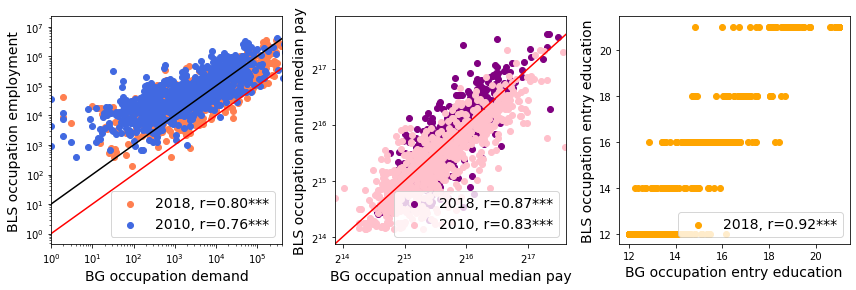

In [53]:
fig = plt.figure(figsize=(12,4))
ax0 = fig.add_subplot(131)
bls_bgon = {}
for j in bls_on18:
    bls_bgon[j] = (yjn[2018][j], bls_on18[j])
x,y = zip(*list(bls_bgon.values()))
plt.scatter(x,y,color="coral", label='2018, r=0.80'+ '***')
corr1=pearsonr(np.log(x),np.log(y))
print(corr1)

bls_bgon = {}
for j in bls_on10:
    bls_bgon[j] = (yjn[2010][j], bls_on10[j])
x,y = zip(*list(bls_bgon.values()))
plt.scatter(x,y,color="royalblue", label='2010, r=0.76'+ '***')
corr2=pearsonr(np.log(x),np.log(y))
print(corr2)

#plt.ylim(1,4000000)
plt.xlim(1,400000)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('BLS occupation employment', fontsize=14)
plt.xlabel('BG occupation demand',fontsize=14)
plt.plot([1,10**6], [1,10**6], 'r-')
plt.plot([1,10**6], [10,10**7], 'k-')
plt.legend(fontsize=14, loc=4)

ax0 = fig.add_subplot(132)
bls_bgop = {}
for j in bls_op18:
    bls_bgop[j] = (yjp[2018][j], float(bls_op18[j]))
x,y = zip(*list(bls_bgop.values()))
plt.scatter(x,y,color="purple", label='2018, r=0.87'+ '***')
corr1=pearsonr(np.log(x), np.log(y))
print(corr1)

bls_bgop = {}
for j in bls_op10:
    bls_bgop[j] = (yjp[2010][j], float(bls_op10[j]))
x1,y1 = zip(*list(bls_bgop.values()))
plt.scatter(x1,y1,color="pink", label='2010, r=0.83'+ '***')
corr2=pearsonr(np.log(x1), np.log(y1))
print(corr2)

plt.ylabel('BLS occupation annual median pay',fontsize=14)
plt.xlabel('BG occupation annual median pay',fontsize=14)
plt.xlim(15000, 200000)
plt.ylim(15000, 250000)
plt.plot([1,10**6], [1,10**6], 'r-')
plt.xscale('log', basex=2)
plt.yscale('log', basey=2)
plt.legend(fontsize=14, loc=4)


ax0 = fig.add_subplot(133)
bls_bgoe = {}
for i, j in zip(df_2018e['2018 National Employment Matrix title and code'], 
               df_2018e['eduy']):
    if i.lower() in yje[2018] and j != 'nan' and j > 0: #and j != 13:
        bls_bgoe[i.lower()] = (yje[2018][i.lower()], j)
print(len(bls_bgoe))
x,y = zip(*list(bls_bgoe.values()))
plt.scatter(x,y,color="orange", label='2018, r=0.92'+ '***')
plt.ylabel('BLS occupation entry education',fontsize=14)
plt.xlabel('BG occupation entry education',fontsize=14)
plt.legend(fontsize=14, loc=4)
corr=pearsonr(x, y)
print(corr)
plt.tight_layout()

#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/SI/BGValidation.pdf') 

### Extended Results: Job Zone

In [234]:
jz = pd.read_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/All_Job_Zones.csv')
onet_soc = pd.read_csv('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/2019_to_SOC_Crosswalk.csv')

In [235]:
socz = {}
jzdict = dict([(i,j) for i,j in zip(jz['Occupation'], jz['Job Zone'])])
onetsocdict = dict([(i,j) for i,j in zip(onet_soc['O*NET-SOC 2019 Title'], onet_soc['2018 SOC Title'])]) 
allsocs = list(onetsocdict.values())
for j in jzdict:
    if j in onetsocdict:
        socz[onetsocdict[j]] = jzdict[j]
#     else:
#         print("not match")
#         if j in allsocs:
#             print("j")
len(socz), len(jzdict), len(onetsocdict)

(798, 923, 1016)

In [236]:
# job zone and job skill change 
zi = defaultdict(lambda:[])
for o in socz:
    if o in jtr:
        zi[socz[o]].append(jtr[o])

for z in range(1,6):
    print(z, len(zi[z]))
zkeys = [1,2,3,4,5]
zmeans = [np.mean(zi[key]) for key in zkeys]
zstd = [calculateCI2(zi[key],'mean',50, 0.8) for key in zkeys]
xz_pos = np.arange(len(zkeys))

1 22
2 204
3 145
4 132
5 99


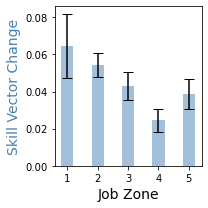

In [237]:
# figure: job zone and job skill change
fig = plt.figure(figsize=(3, 3),facecolor='white')

f3_ax2 = fig.add_subplot(111)
f3_ax2.bar(xz_pos, zmeans, yerr=zstd, width = 0.4, color = 'steelblue', align='center', alpha=0.5, ecolor='black', capsize=5)
f3_ax2.set_ylabel('Skill Vector Change', color = 'steelblue', fontsize=14)
f3_ax2.set_xlabel('Job Zone', fontsize=14)
f3_ax2.set_xticks(xz_pos)
f3_ax2.set_xticklabels(zkeys, size=10)
f3_ax2.yaxis.set_tick_params(labelsize=10)
#plt.xticks(rotation=30)
#plt.ylim(0,0.08)
plt.tight_layout()
#plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/Results/IndividualFigure/SI/JobZoneSKillChange.pdf')

### Extended Results: Most Significant Skill Transition as Skill Change

In [ ]:
def GetNearestSkill(jys, model):
    
    jsd = defaultdict(lambda:defaultdict(lambda:''))
    n=0
    for j in jys:
        n+=1
        flushPrint(n)
        if 2010 in jys[j] and 2018 in jys[j]:
            for sn in jys[j][2018]:
                if sn in jys[j][2010]:
                    jsd[j][sn] = (0, sn)
                elif sn in model.wv:
                    dis=10000
                    ns=""
                    for so in jys[j][2010]:
                        if so in model.wv:
                            d=1-np.dot(model.wv[sn], model.wv[so])/(np.linalg.norm(model.wv[sn])* np.linalg.norm(model.wv[so]))
                            if d <= dis:
                                dis=d
                                ns=so     
                    if dis!=10000:
                        jsd[j][sn] = (dis, ns)

            jsd[j] = dict(sorted(jsd[j].items(), key=operator.itemgetter(1), reverse=True))
    
    return jsd

# max distance with different percentile criteria
def PickMaxDistance(perc, jsd):
    jmc = dict()
    for j in jsd:
        ind = max(round(len(jsd[j])*perc)-1, 0)
        sl = list(jsd[j].items())
        jmc[j] = sl[ind][1][0]
    jmc = dict(sorted(jmc.items(), key=operator.itemgetter(1), reverse=True))  
    
    return jmc

# average of skill group of max distances defined by different percentile criteria
def AvgMaxDistance(perc, jsd):
    jmc = dict()
    for j in jsd:
        ind = max(round(len(jsd[j])*perc), 1)
        sl = list(jsd[j].items())[:ind]
        jmc[j] = np.mean([e[1][0] for e in sl])
    jmc = dict(sorted(jmc.items(), key=operator.itemgetter(1), reverse=True)) 
    
    return jmc

In [ ]:
# key independent variable: skill number
def JobNSkill(dictjys):
    dictosn = {}
    for job in dictjys:
        snlst = []
        for yr in dictjys[job]:
            if len(dictjys[job][yr]) != 0:
                snlst.append(len(dictjys[job][yr]))
        if snlst:
            dictosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
    dictosn = dict(sorted(dictosn.items(), key=operator.itemgetter(1),reverse=True))
    
    return dictosn
# key depedent variable: job skill change
def JobChange(dictjys, method, perc):
    
    if method == "average":
        
        dictjyv=defaultdict(lambda:defaultdict(lambda:''))
        for j in dictjys:
            for y in dictjys[j]:
                dictjyv[j][y] = np.mean([model.wv[s] for s in dictjys[j][y] if s in model.wv], axis=0)

        dictjtr = {}
        for j in dictjyv:
            if 2010 in dictjyv[j] and 2018 in dictjyv[j]:
                if j in jyn:
                    if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                        jtrrr = np.dot(dictjyv[j][2018], dictjyv[j][2010]
                                      )/(np.linalg.norm(dictjyv[j][2018])* np.linalg.norm(dictjyv[j][2010]))
                        if type(jtrrr) == np.float32:
                            dictjtr[j] = 1 - jtrrr

        dictjtr = dict(sorted(dictjtr.items(), key=operator.itemgetter(1)))
    
    if method == "max":
        jsd=GetNearestSkill(dictjys, model)
        dictjtr = PickMaxDistance(perc, jsd)
    
    if method == "avgmax":
        jsd=GetNearestSkill(dictjys, model)
        dictjtr = AvgMaxDistance(perc, jsd)
    
    return dictjtr

In [366]:
def buildregdata(jtrwa):
    regdf=pd.DataFrame(columns = ['Occupation','SkillChange', 'LogSkillN', 'Education', 'LogPay'])
    for j in jtr:
        if j in osn and j in oe and j in op:
            regdf=regdf.append({'Occupation': j, 'SkillChange': jtrwa[j], 'LogSkillN': np.log(osn[j]),
                    'Education': oe[j], 'LogPay': np.log(op[j])}, ignore_index = True)
            
    return regdf

In [367]:
jtrm0 = JobChange(jys, "max", 0)
reg_df_max0 = buildregdata(jtrm0)

jtrm5 = JobChange(jys, "max", 0.05)
reg_df_max5 = buildregdata(jtrm5)

jtrm10 = JobChange(jys, "max", 0.10)
reg_df_max10 = buildregdata(jtrm10)

831

In [372]:
mod1= smf.ols('SkillChange ~ LogSkillN', data=reg_df_max0)
res1 = mod1.fit()

mod2= smf.ols('SkillChange ~ LogPay', data=reg_df_max0)
res2 = mod2.fit()

mod3= smf.ols('SkillChange ~ Education', data=reg_df_max0)
res3 = mod3.fit()

mod4= smf.ols('SkillChange ~ LogSkillN', data=reg_df_max5)
res4 = mod4.fit()

mod5= smf.ols('SkillChange ~ LogPay', data=reg_df_max5)
res5 = mod5.fit()

mod6= smf.ols('SkillChange ~ Education', data=reg_df_max5)
res6 = mod6.fit()

mod7= smf.ols('SkillChange ~ LogSkillN', data=reg_df_max10)
res7 = mod7.fit()

mod8= smf.ols('SkillChange ~ LogPay', data=reg_df_max10)
res8 = mod8.fit()

mod9= smf.ols('SkillChange ~ Education', data=reg_df_max10)
res9 = mod9.fit()

stargazer = Stargazer([res1, res2, res3, res4, res5, res6, res7, res8, res9])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change')
stargazer.custom_columns(['Max', 'Max','Max','Rank 5\% ', 'Rank 5\% ','Rank 5\% ','Rank 10\% ','Rank 10\% ','Rank 10\% '], [1, 1, 1,1,1,1,1,1,1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillN',  'LogPay', 'Education'])

stargazer.rename_covariates({'LogSkillN': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education'})
stargazer.significance_levels([0.05, 0.01, 0.001])
#stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
stargazer

In [373]:
print(stargazer.render_html())

Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change<br><table style="text-align:center"><tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="9"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Max</td><td colspan="1">Max</td><td colspan="1">Max</td><td colspan="1">Rank 5\% </td><td colspan="1">Rank 5\% </td><td colspan="1">Rank 5\% </td><td colspan="1">Rank 10\% </td><td colspan="1">Rank 10\% </td><td colspan="1">Rank 10\% </td></tr><tr><td colspan="10" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Complexity</td><td>-0.010<sup>***</sup></td><td></td><td></td><td>-0.053<sup>***</sup></td><td></td><td></td><td>-0.062<sup>***</sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td><td></td><td></td><td>(0.002)</td><td></td><td></td><td>(0.002)</td><t

In [238]:
# # use the same dataset as other regressions
# lcllocjtrm0 = JobChange(lcllocjys, "max", 0)
# lcslocjtrm0 = JobChange(lcslocjys, "max", 0)
# scllocjtrm0 = JobChange(scllocjys, "max", 0)
# scslocjtrm0 = JobChange(scslocjys, "max", 0)
# reg_df_max0 = reg_dataframe(lcllocjtrm0, lcslocjtrm0, scllocjtrm0, scslocjtrm0)

# lcllocjtrm5 = JobChange(lcllocjys, "max", 0.05)
# lcslocjtrm5 = JobChange(lcslocjys, "max", 0.05)
# scllocjtrm5 = JobChange(scllocjys, "max", 0.05)
# scslocjtrm5 = JobChange(scslocjys, "max", 0.05)
# reg_df_max5 = reg_dataframe(lcllocjtrm5, lcslocjtrm5, scllocjtrm5, scslocjtrm5)

# lcllocjtrm10 = JobChange(lcllocjys, "max", 0.1)
# lcslocjtrm10 = JobChange(lcslocjys, "max", 0.1)
# scllocjtrm10 = JobChange(scllocjys, "max", 0.1)
# scslocjtrm10 = JobChange(scslocjys, "max", 0.1)
# reg_df_max10 = reg_dataframe(lcllocjtrm10, lcslocjtrm10, scllocjtrm10, scslocjtrm10)

781

In [239]:
# mod5= smf.ols('SkillChange ~ LogSkillNAll + Education + LogPay', data=reg_df_max0)
# res5 = mod5.fit()

# mod6= smf.ols('SkillChange ~ LogSkillNAll + Education + LogPay', data=reg_df_max5)
# res6 = mod6.fit()

# mod7= smf.ols('SkillChange ~ LogSkillNAll + Education + LogPay', data=reg_df_max10)
# res7 = mod7.fit()

# stargazer = Stargazer([res5, res6, res7])

# stargazer.title('Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change')
# stargazer.custom_columns(['Max Skill Transition', 'Rank 5\% Max Skill Transition', 'Rank 10\% Max Skill Transition'], [1, 1, 1])
# stargazer.show_model_numbers(False)
# stargazer.covariate_order(['LogSkillNAll',  'LogPay', 'Education'])

# stargazer.rename_covariates({'LogSkillNAll': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
#     'Education': 'Education'})
# stargazer.significance_levels([0.05, 0.01, 0.001])
# #stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
# stargazer

In [240]:
print(stargazer.render_html())

Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change<br><table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Max Skill Transition</td><td colspan="1">Rank 5\% Max Skill Transition</td><td colspan="1">Rank 10\% Max Skill Transition</td></tr><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Complexity</td><td>-0.015<sup>***</sup></td><td>-0.048<sup>***</sup></td><td>-0.056<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td><td>(0.002)</td><td>(0.002)</td></tr><tr><td style="text-align:left">Log Annual Pay</td><td>-0.017<sup>*</sup></td><td>-0.014<sup>*</sup></td><td>-0.015<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td>(0.007)</td><td>(0.006)<

### Extended Results: Upskilling of Low-skilled Jobs towards High-skilled Jobs

In [194]:
# match to nearest occupation in the other skill group
def nearestjob(j1,j2,dis, jp, year):
    
    if j1 in jtr and j2 in jtr:
        d=1-np.dot(jyv[j1][year], jyv[j2][year])/(np.linalg.norm(jyv[j1][year])* np.linalg.norm(jyv[j2][year]))
        if d<dis:
            dis=d
            jp=j2
            
    return dis, jp

In [195]:
# skill group
def classifySkillGroup(os, jtr, cond):
    sj = defaultdict(lambda:[])
    for j in os:
        if j in jtr:
            if os[j]>=cond:
                sj['high'].append(j)
            else:
                sj['low'].append(j)  
    return sj

In [201]:
def GetPairs(skillj):
    pairs10 = defaultdict(lambda:0)
    pairs18 = defaultdict(lambda:0)
    compdict={'high':'low', 'low': 'high'}
    for g in skillj:
        for j1 in skillj[g]:
            dis10=10000
            jp10=''
            dis18=10000
            jp18=''
            for j2 in skillj[compdict[g]]:
                dis10, jp10 = nearestjob(j1,j2,dis10, jp10, 2010)
                dis18, jp18 = nearestjob(j1,j2,dis18, jp18, 2018)
            if dis10 != 10000:
                pairs10[(j1,jp10)] = dis10
            if dis18 != 10000:
                pairs18[(j1,jp18)] = dis18   
    print(len(pairs10), len(pairs18))
    
    return pairs10, pairs18

In [202]:
sj = classifySkillGroup(osn, jtr, np.median(list(osn.values())))
spairs10, spairs18 = GetPairs(sj)
np.mean(list(spairs10.values())), np.mean(list(spairs18.values())), stats.ttest_rel(list(spairs10.values()), list(spairs18.values()))

727 727


(0.0887652315824527,
 0.0661466570963066,
 Ttest_relResult(statistic=20.497855744756972, pvalue=5.033764160911014e-74))

In [219]:
cleaned_op = {}
for o in op:
    if not math.isnan(op[o]):
        cleaned_op[o]=op[o]
pj = classifySkillGroup(cleaned_op, jtr, np.median(list(cleaned_op.values())))
ppairs10, ppairs18 = GetPairs(pj)
np.mean(list(ppairs10.values())), np.mean(list(ppairs18.values())), stats.ttest_rel(list(ppairs10.values()), list(ppairs18.values()))

721 721


(0.08981245673479882,
 0.07051716275750847,
 Ttest_relResult(statistic=15.812108779937885, pvalue=1.4588509542103245e-48))

In [204]:
ej = classifySkillGroup(oe, jtr, 16)
epairs10, epairs18 = GetPairs(ej)
np.mean(list(epairs10.values())), np.mean(list(epairs18.values())), stats.ttest_rel(list(epairs10.values()), list(epairs18.values()))

721 721


(0.1356854994320175,
 0.11585051201583609,
 Ttest_relResult(statistic=14.373444578014215, pvalue=2.2703778334851705e-41))

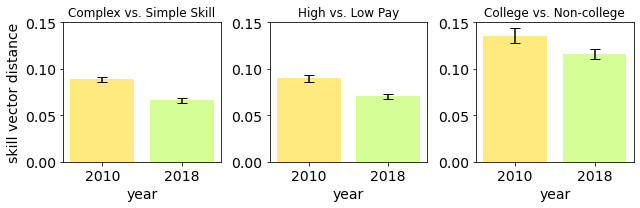

In [232]:
fig = plt.figure(figsize=(9, 3),facecolor='white')


# skill number
f1 = fig.add_subplot(131)
ymeans = [np.mean(list(spairs10.values())), np.mean(list(spairs18.values()))]
ystd = [calculateCI2(list(spairs10.values()),'mean',50, 0.8), calculateCI2(list(spairs18.values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']
f1.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'greenyellow', align='center', alpha=0.5, ecolor='black', capsize=5)
f1.set_ylabel('skill vector distance', fontsize=14)
f1.set_xlabel('year', fontsize=14)
f1.set_xticks(xy_pos)
f1.set_xticklabels([2010, 2018],size=14)
f1.yaxis.set_tick_params(labelsize=14)
plt.title("Complex vs. Simple Skill")
plt.ylim(0,0.15)
plt.tight_layout()

# pay
f2 = fig.add_subplot(132)
ymeans = [np.mean(list(ppairs10.values())), np.mean(list(ppairs18.values()))]
ystd = [calculateCI2(list(ppairs10.values()),'mean',50, 0.8), calculateCI2(list(ppairs18.values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']
f2.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f2.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'greenyellow', align='center', alpha=0.5, ecolor='black', capsize=5)
#f2.set_ylabel('skill vector distance', fontsize=14)
f2.set_xlabel('year', fontsize=14)
f2.set_xticks(xy_pos)
f2.set_xticklabels([2010, 2018],size=14)
f2.yaxis.set_tick_params(labelsize=14)
plt.title("High vs. Low Pay")
plt.ylim(0,0.15)
plt.tight_layout()

# education
f3 = fig.add_subplot(133)
ymeans = [np.mean(list(epairs10.values())), np.mean(list(epairs18.values()))]
ystd = [calculateCI2(list(epairs10.values()),'mean',50, 0.8), calculateCI2(list(epairs18.values()),'mean',50, 0.8)]
xy_pos = np.arange(len(ymeans))
ykeys = ['2010', '2018']
f3.bar(xy_pos[0], ymeans[0], yerr=ystd[0], color = 'gold', align='center', alpha=0.5, ecolor='black', capsize=5)
f3.bar(xy_pos[1], ymeans[1], yerr=ystd[1], color = 'greenyellow', align='center', alpha=0.5, ecolor='black', capsize=5)
#f3.set_ylabel('skill vector distance', fontsize=14)
f3.set_xlabel('year', fontsize=14)
f3.set_xticks(xy_pos)
f3.set_xticklabels([2010, 2018],size=14)
f3.yaxis.set_tick_params(labelsize=14)
plt.title("College vs. Non-college")
plt.ylim(0,0.15)
plt.tight_layout()

plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/SIfigtable/HighLowSkillGroupMoveCloser.png')

### Extended Results: Unemployment and Skill Change

In [375]:
# unemployment rate 2010-2018
uer1018 = [9.6, 8.9, 8.1, 7.4, 6.2, 5.3, 4.9, 4.4]#, 3.9]
uer1018 = [u/100 for u in uer1018] 
yuer = zip(list(range(2010, 2019)), uer1018)
yuer = dict(yuer)

In [274]:
# JOB-SKILL DATA
# without filtering the skills
allyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/IntermediateData/occ_year_skill_freq.txt', 'r') as f:
    for line in f:
        line_lst = line.split("\t")
        job = line_lst[0]
        year = int(line_lst[1])
        skills = line_lst[2:]
        if year >= 2010 or year<=2018:
            if len(skills) > 5:
                for skill_tfidf in skills:
                    skill = skill_tfidf.split('_')[0].lower()
                    tfidf = float(skill_tfidf.split('_')[1])
                    allyjas[year][job][skill] = tfidf
                    
# job - top 5% defining skills
alljys = defaultdict(lambda:defaultdict(lambda:[]))
allsyj = defaultdict(lambda:defaultdict(lambda:[]))
for year in allyjas:
    for job in allyjas[year]:
        threshold = np.quantile(list(allyjas[year][job].values()), [0.95])
        #threshold = np.mean(list(yjas[year][job].values()))
        for skill in allyjas[year][job]:
            if allyjas[year][job][skill] > threshold:
                alljys[job][year].append(skill)
                allsyj[skill][year].append(job)
        if len(alljys[job][year]) < 5:
            #print(job, year)
            del alljys[job][year]
            fulllist = allsyj[skill][year]
            allsyj[skill][year] = [value for value in fulllist if value != job]
            
# job vector
# 200 dimension Job-Year-Vector
allyjv = defaultdict(lambda:defaultdict(lambda:''))
alljyv = defaultdict(lambda:defaultdict(lambda:''))
for j in alljys:
    for y in alljys[j]:
        alljyv[j][y] = np.mean([model.wv[s] for s in alljys[j][y] if s in model.wv],axis=0)
        allyjv[y][j] = np.mean([model.wv[s] for s in alljys[j][y] if s in model.wv],axis=0)
        #jyv[j][y] = np.sum([model.wv[s] for s in jys[j][y] if s in model.wv],axis=0)

In [275]:
len(jtr)

727

In [277]:
# job stability from 2010 to 2018: dot product between 2 job vectors
yjtr = defaultdict(lambda:defaultdict(lambda:""))
yavgc = {}
for y in range(2010, 2018):
    for j in allyjv[y]:
        if y+1 in alljyv[j] and j in jtr:
            yjtr[y][j] = 1- np.dot(alljyv[j][y], alljyv[j][y+1])/(np.linalg.norm(alljyv[j][y])* np.linalg.norm(alljyv[j][y+1]))
    yjtr[y] = dict(sorted(yjtr[y].items(), key=operator.itemgetter(1)))
    yavgc[y] = np.mean(list(yjtr[y].values())) 

yjtr = dict(sorted(yjtr.items(), key=operator.itemgetter(0)))
yavgc = dict(sorted(yavgc.items(), key=operator.itemgetter(0)))

In [294]:
yavgc

{2010: 0.02766351270082906,
 2011: 0.02484441602098349,
 2012: 0.025479415067299668,
 2013: 0.020749672816904898,
 2014: 0.01940603728471465,
 2015: 0.019610293968978336,
 2016: 0.01792257761495501,
 2017: 0.01794984940813529}

In [377]:
print(pearsonr(uer1018, list(yavgc.values())))
# plt.scatter(uer1018, list(yavgc.values()))
# plt.xlabel("unemployment rate")
# plt.ylabel("average occupational skill change")

(0.9498244720541461, 0.0003040377992264039)


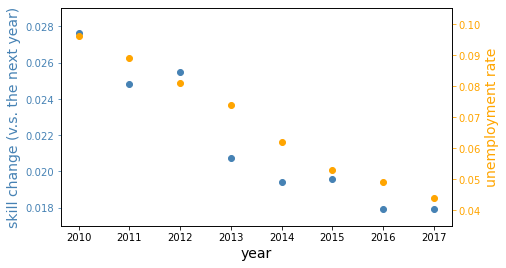

In [307]:
# Create the first set of scatter plots (aligned with the left axes)
#fig, ax1 = plt.subplots()
fig, ax1 = plt.subplots(figsize=(7, 4),facecolor='white')
x, y1 =zip(*yavgc.items())
ax1.scatter(x, y1, color='steelblue')
ax1.set_ylim(0.017, 0.029)
ax1.tick_params(axis='y', labelcolor='steelblue', color='steelblue')


# Create the second set of scatter plots (aligned with the right axes)
ax2 = ax1.twinx()
x, y2 =zip(*yuer.items())
ax2.scatter(x, y2, color='orange')
ax2.set_ylim(0.035, 0.105)
ax2.tick_params(axis='y', labelcolor='orange', color='orange')

# Customize the plots
ax1.set_xlabel('year', fontsize=14)
ax1.set_ylabel('skill change (v.s. the next year)', color='steelblue', fontsize=14)
ax2.set_ylabel('unemployment rate', color='orange', fontsize=14)


plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/SIfigtable/uerskillchange.png')

plt.show()

### Extended Results: Re-educational Cost Reflected by Occupational Skill Change

In [64]:
SocSmSnEdudSvd = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:[])))
SocSmSnEdudSvdAll = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:[])))
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/SocSnSaddEdudSvd_10perc821seed.txt', 'r') as f:
    for line in f:
        line_lst = line[:-1].split('\t')
        if float(line_lst[3])>0:
            SocSmSnEdudSvd[line_lst[0]][int(line_lst[1])][int(line_lst[2])].append([float(k) for k in line_lst[3:]])
        SocSmSnEdudSvdAll[line_lst[0]][int(line_lst[1])][int(line_lst[2])].append([float(k) for k in line_lst[3:]])

In [65]:
len(SocSmSnEdudSvd), len(SocSmSnEdudSvdAll)

(448, 652)

#### Number of added skill distribution of occupation

In [66]:
SocAddN = defaultdict(lambda:defaultdict(lambda:0))
SocAddNlst = defaultdict(lambda:[])
AddN=defaultdict(lambda:0)
for occ in SocSmSnEdudSvd:
    for m in SocSmSnEdudSvd[occ]:
        for n in SocSmSnEdudSvd[occ][m]:
            SocAddN[occ][n-m]+=len(SocSmSnEdudSvd[occ][m][n])
            AddN[n-m]+=len(SocSmSnEdudSvd[occ][m][n])
            SocAddNlst[occ]+=[n-m]*len(SocSmSnEdudSvd[occ][m][n])
    SocAddN[occ] = dict(sorted(SocAddN[occ].items(), key=operator.itemgetter(1), reverse=True))
AddN=dict(sorted(AddN.items(), key=operator.itemgetter(1), reverse=True))    

(0.0, 50.0)

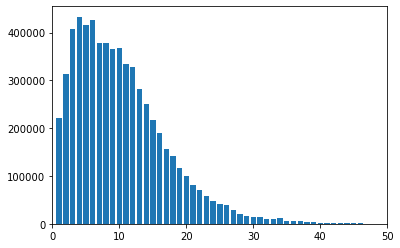

In [67]:
plt.bar(list(AddN.keys()), list(AddN.values()))
plt.xlim(0, 50)

In [68]:
# find occupations, get density plot peak for each occupation
AddnSoc=defaultdict(lambda:defaultdict(lambda:0))
socpeak={}
for occ in SocAddNlst:
    data = SocAddNlst[occ]
    if len(set(data))==1:
        an=data[0]
    else:
        plot=sns.kdeplot(data)
        kde_data = plot.get_lines()[0].get_data()
        kde_x, kde_y = kde_data
        an=round(kde_x[np.argmax(kde_y)])
        plt.clf()
        if an not in SocAddN[occ]:
            dis=10000
            for n in SocAddN[occ]:
                if abs(n-kde_x[np.argmax(kde_y)]) <= dis:
                    dis = abs(n-kde_x[np.argmax(kde_y)])
                    an=n 
            
    socpeak[occ] = an
    AddnSoc[an][occ] = SocAddN[occ][an]

for addn in AddnSoc:
    AddnSoc[addn] = dict(sorted(AddnSoc[addn].items(), key=operator.itemgetter(1), reverse=True))
AddnSoc = dict(sorted(AddnSoc.items(), key=operator.itemgetter(0)))

<Figure size 432x288 with 0 Axes>

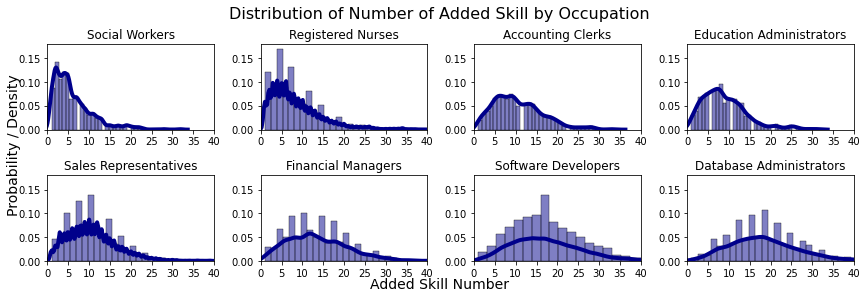

In [99]:
# 4*2 figure
occupations = ['Social Workers, All Other', 'Registered Nurses',
         'Bookkeeping, Accounting, and Auditing Clerks','Education Administrators, Postsecondary',
       'Sales Representatives, Wholesale and Manufacturing, Except Technical and Scientific Products',
            'Financial Managers', 'Software Developers, Applications','Database Administrators']
labels={'Preschool Teachers, Except Special Education': 'Preschool Teachers',
        'Social Workers, All Other': 'Social Workers',
        'Education Administrators, Postsecondary': 'Education Administrators',
        'Bookkeeping, Accounting, and Auditing Clerks': 'Accounting Clerks',
        'Software Developers, Applications':'Software Developers',
       'Sales Representatives, Wholesale and Manufacturing, Except Technical and Scientific Products': 'Sales Representatives'}

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(12,4))
fig.patch.set_facecolor('white')
fig.suptitle("Distribution of Number of Added Skill by Occupation", fontsize=16)

# Add x and y labels for the entire figure
fig.text(0.5, 0.0000001, 'Added Skill Number', ha='center', fontsize=14)
fig.text(0.000000001, 0.5, 'Probability / Density', va='center', rotation='vertical', fontsize=14)
for i, occ in enumerate(occupations):
    row, col = divmod(i, 4)
    data = SocAddNlst[occ]
    if occ in list(labels.keys()):
        label =labels[occ]
    else:
        label=occ
    ax = axes[row, col]
    ax.set_title(label)
    
    # histogram
    sns.histplot(data, bins=int(180/5), stat='probability', color='darkblue', edgecolor='black', 
                 alpha=0.5, ax=ax)
    # Add KDE
    plot=sns.kdeplot(data, color='darkblue', linewidth=4, label='KDE', ax=ax)
    # Set the x and y lim and ticks
    custom_xticks = list(range(0, 41, 5))
    ax.set(xticks=custom_xticks)
    ax.set_xlim(0, 40)
    ax.set_ylim(0, 0.18)
    ax.set_ylabel('')

plt.tight_layout()
plt.subplots_adjust(top=0.85)
plt.savefig('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/results/SIfig/AddedSkillDistribution_10perc821seed.png')
plt.show()


#### Skill distance and education difference

In [71]:
# data
svdedud = []
osvdedud = []
socs=defaultdict(lambda:0)
#select the peak with +-1 slide window for each occupation
for occ in SocSmSnEdudSvdAll:
    if occ in socpeak:
        add=[socpeak[occ], socpeak[occ]-1, socpeak[occ]+1]
        osvdedudlst=defaultdict(lambda:[])
        for sm in SocSmSnEdudSvdAll[occ]:
            for sn in SocSmSnEdudSvdAll[occ][sm]:
                if sn-sm in add:
                    for unit in SocSmSnEdudSvdAll[occ][sm][sn]:
                        svdedud.append((unit[1], unit[0]))
                        osvdedudlst[sn-sm].append((unit[1], unit[0]))
                        socs[occ]+=1

        for n in osvdedudlst:
            osvdedud.append(tuple([sum(t) / len(osvdedudlst[n]) for t in zip(*osvdedudlst[n])]))
# all instances
len(svdedud), len(socs), len(osvdedud)

(6585524, 448, 1257)

In [73]:
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/svdedud_10perc821seed.txt', 'w') as f:
    for svd, edud in svdedud:
        line="\t".join([str(svd), str(edud)])
        f.write(line+'\n')
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/osvdedud_10perc821seed.txt', 'w') as f:
    for osvd, edud in osvdedud:
        line="\t".join([str(osvd), str(edud)])
        f.write(line+'\n')

In [186]:
osvdedud = []
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/osvdedud_10perc821seed.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        osvdedud.append((float(linelst[0]), float(linelst[1])))
svdedud = []
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/svdedud_10perc821seed.txt', 'r') as f:
    for line in f:
        linelst = line[:-1].split("\t")
        svdedud.append((float(linelst[0]), float(linelst[1])))

In [187]:
# post level correlation
x, y = zip(*svdedud)
spearmanr(x, y), pearsonr(x, y)

(SpearmanrResult(correlation=0.0550634213908414, pvalue=0.0),
 (0.041796178792241186, 0.0))

In [227]:
# occupation average level correlation
# post level correlation
x, y = zip(*osvdedud)
spearmanr(x, y), pearsonr(x, y)

(SpearmanrResult(correlation=0.13521232405663985, pvalue=1.5003825443311582e-06),
 (0.14572700957545776, 2.111788271143556e-07))

In [229]:
# put variables in a dataframe
reg_df=pd.DataFrame(columns = ["SkillDistance", "EduDifference"])
xs, ys = zip(*svdedud)
reg_df["SkillDistance"]=xs
reg_df["EduDifference"]=ys
len(reg_df)

6585524

In [228]:
oreg_df=pd.DataFrame(columns = ["SkillDistance", "EduDifference", "ZSkillDistance"])

# post level z-score regression
x, y = zip(*osvdedud)
z_scores = np.array(x)
z_scores = (z_scores - z_scores.mean()) / z_scores.std()

oreg_df["SkillDistance"]=x
oreg_df["EduDifference"]=y
oreg_df["ZSkillDistance"]=z_scores
len(oreg_df)

1257

In [230]:
resf1 =  smf.ols("EduDifference ~ SkillDistance", data=reg_df).fit()
resf2 =  smf.ols("EduDifference ~ SkillDistance", data=oreg_df).fit()
resf3 =  smf.ols("EduDifference ~ ZSkillDistance", data=oreg_df).fit()

stargazerf = Stargazer([resf1, resf2, resf3])

stargazerf.title('Predicting Education Year Difference with Skill Distance')
stargazerf.custom_columns(['Job Post Unit', 'Occupation Aggregated Unit', 'Occupation Aggregated Unit'], [1, 1, 1])
stargazerf.show_model_numbers(False)
stargazerf.covariate_order(['SkillDistance', 'ZSkillDistance'])
stargazerf.rename_covariates({'SkillDistance': 'Skill Distance', 'ZSkillDistance': 'Skill Distance Z-score'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf

In [241]:
print(stargazerf.render_html())

Predicting Education Year Difference with Skill Distance<br><table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:EduDifference</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Job Post Unit</td><td colspan="1">Occupation Aggregated Unit</td><td colspan="1">Occupation Aggregated Unit</td></tr><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Distance</td><td>0.741<sup>***</sup></td><td>1.839<sup>***</sup></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.007)</td><td>(0.352)</td><td></td></tr><tr><td style="text-align:left">Skill Distance Z-score</td><td></td><td></td><td>0.172<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td></td><td></td><td>(0.033)</td></tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align: 

#### Numbers used in examples

In [84]:
# z-score for the skill distance in the job pair example
x, y = zip(*osvdedud)
z_scores = np.array(x)
(0.17 - z_scores.mean()) / z_scores.std()

-1.132695001448084

In [91]:
# skill change of high and low education group
hc = []
lc = []
for j in jtr:
    if j in oe:
        if oe[j]>=16:
            hc.append(jtr[j])
        else:
            lc.append(jtr[j])
# skill change, predicted educational cost
print(np.mean(hc), np.mean(lc), np.mean(hc)*1.84, np.mean(lc)*1.84)

0.031813181486705804 0.0483680062152289 0.05853625393553868 0.08899713143602118


In [92]:
# high pay and low pay jobs' skill change
hp=[]
lp=[]
plist = [x for x in list(op.values()) if math.isnan(x) == False]
for j in jtr:
    if j in op:
        if op[j] >= np.quantile(plist, [0.75]):
            hp.append(jtr[j])
        elif op[j] < np.quantile(plist, [0.25]):
            lp.append(jtr[j])
print(np.mean(hp), np.mean(lp), np.mean(hp)*1.84, np.mean(lp)*1.84)

0.033671291974874645 0.0502329600805586 0.06195517723376935 0.09242864654822783


In [93]:
# schooling cost from community college: https://educationdata.org/average-cost-of-community-college
0.06*2055*2, 0.09*2055*2

(246.6, 369.9)

In [94]:
# computer programmer and food batchmaker: skill change, predicted education change, predicted schooling cost
print(jtr['Food Batchmakers'], jtr["Computer Programmers"], jtr['Food Batchmakers']*1.84, jtr["Computer Programmers"]*1.84, jtr['Food Batchmakers']*1.84*2055*2, jtr["Computer Programmers"]*1.84*2055*2)

0.08175450563430786 0.01701796054840088 0.15042829036712646 0.03131304740905762 618.2602734088897 128.6966248512268


### Extended Results: control for employer concentration

In [100]:
# job-core skill
def YearJobSkillFreq(filename):
    dictyjas = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
    with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/'+filename, 'r') as f:
        for line in f:
            line_lst = line.split("\t")
            job = line_lst[0]
            year = int(line_lst[1])
            skills = line_lst[2:]
            if year != 2019:
                if len(skills) > 5:
                    for skill_tfidf in skills:
                        skill = skill_tfidf.split('_')[0].lower()
                        tfidf = float(skill_tfidf.split('_')[1])
                        dictyjas[year][job][skill] = tfidf
                        
    return dictyjas

def JobYearDefSkill(dictyjas, quant):
    dictjys = defaultdict(lambda:defaultdict(lambda:[]))
    for year in dictyjas:
        for job in dictyjas[year]:
            threshold = np.quantile(list(dictyjas[year][job].values()), [quant])
            for skill in dictyjas[year][job]:
                if dictyjas[year][job][skill] > threshold:
                    dictjys[job][year].append(skill)
            if len(dictjys[job][year]) < 5:
                del dictjys[job][year]

    return dictjys

lcllocyjas = YearJobSkillFreq('lclcz_occ_year_skill_freq.txt')
lcllocjys = JobYearDefSkill(lcllocyjas, 0.95)

lcslocyjas = YearJobSkillFreq('lcscz_occ_year_skill_freq.txt')
lcslocjys = JobYearDefSkill(lcslocyjas, 0.95)

scllocyjas = YearJobSkillFreq('sclcz_occ_year_skill_freq.txt')
scllocjys = JobYearDefSkill(scllocyjas, 0.95)

scslocyjas = YearJobSkillFreq('scscz_occ_year_skill_freq.txt')
scslocjys = JobYearDefSkill(scslocyjas, 0.95)

In [101]:
len(lcllocjys), len(lcslocjys), len(scllocjys), len(scslocjys)

(829, 822, 816, 781)

In [102]:
# key independent variable: skill number
def JobNSkill(dictjys):
    dictosn = {}
    for job in dictjys:
        snlst = []
        for yr in dictjys[job]:
            if len(dictjys[job][yr]) != 0:
                snlst.append(len(dictjys[job][yr]))
        if snlst:
            dictosn[job] = round(np.mean(snlst)) # np.log(round(np.mean(snlst)))
    dictosn = dict(sorted(dictosn.items(), key=operator.itemgetter(1),reverse=True))
    
    return dictosn

lcllocosn = JobNSkill(lcllocjys)
lcslocosn = JobNSkill(lcslocjys)
scllocosn = JobNSkill(scllocjys)
scslocosn = JobNSkill(scslocjys)

In [157]:
# key depedent variable: job skill change
def JobChange(dictjys, method, perc):
    
    if method == "average":
        
        dictjyv=defaultdict(lambda:defaultdict(lambda:''))
        for j in dictjys:
            for y in dictjys[j]:
                dictjyv[j][y] = np.mean([model.wv[s] for s in dictjys[j][y] if s in model.wv], axis=0)

        dictjtr = {}
        for j in dictjyv:
            if 2010 in dictjyv[j] and 2018 in dictjyv[j]:
                if j in jyn:
                    if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                        jtrrr = np.dot(dictjyv[j][2018], dictjyv[j][2010]
                                      )/(np.linalg.norm(dictjyv[j][2018])* np.linalg.norm(dictjyv[j][2010]))
                        if type(jtrrr) == np.float32:
                            dictjtr[j] = 1 - jtrrr

        dictjtr = dict(sorted(dictjtr.items(), key=operator.itemgetter(1)))
    
    if method == "max":
        jsd=GetNearestSkill(dictjys, model)
        dictjtr = PickMaxDistance(perc, jsd)
    
    if method == "avgmax":
        jsd=GetNearestSkill(dictjys, model)
        dictjtr = AvgMaxDistance(perc, jsd)
    
    return dictjtr

In [ ]:
lcllocjtr = JobChange(lcllocjys, "average", None)
lcslocjtr = JobChange(lcslocjys, "average", None)
scllocjtr = JobChange(scllocjys, "average", None)
scslocjtr = JobChange(scslocjys, "average", None)

In [104]:
# occupations that appear in all 4 datasets
commonj=list(set(lcllocjtr.keys()).intersection(set(lcslocjtr)).intersection(set(scllocjtr)).intersection(set(scslocjtr)))
len(commonj)

329

In [105]:
# key control: employer concentration
Lloc_OCCYEC=defaultdict(lambda:[])
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/LLOCyear_occ_empcon.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        yr = int(line_lst[0])
        occ = line_lst[1]
        ec = float(line_lst[2])
        if not np.isnan(ec):
            Lloc_OCCYEC[occ].append(ec)
            
Lloc_OCCEC=defaultdict(lambda:0)
for occ in Lloc_OCCYEC:
    Lloc_OCCEC[occ] = np.mean(Lloc_OCCYEC[occ])

Sloc_OCCYEC=defaultdict(lambda:[])
with open('/Users/ditong/Dropbox (MIT)/skills/SkillPaper/revision/NHB/data/SLOCyear_occ_empcon.txt', 'r') as f1:
    for line in f1:
        line_lst = line.split('\t')
        yr = int(line_lst[0])
        occ = line_lst[1]
        ec = float(line_lst[2])
        if not np.isnan(ec):
            Sloc_OCCYEC[occ].append(ec)
            
Sloc_OCCEC=defaultdict(lambda:0)
for occ in Sloc_OCCYEC:
    Sloc_OCCEC[occ] = np.mean(Sloc_OCCYEC[occ])

In [106]:
# put variables in a dataframe
reg_df=pd.DataFrame(columns = ['Occupation', 'SkillChange', 'LogSkillN', 'LogSkillNAll', 'Education', 'LogPay', 'LargeEmployer',
                'LargeMarket','EmployerConcentration', 'LargeEmployer_LogSkillN', 'LargeMarket_LogSkillN',
                               'LargeEmployer_LogSkillNAll', 'LargeMarket_LogSkillNAll',
                    'LargeEmployer_LogPay', 'LargeMarket_LogPay', 'LargeEmployer_Education', 'LargeMarket_Education'])

for j in lcllocjtr:
    if j in lcllocosn and j in oe and j in op and j in Lloc_OCCEC: #and j in commonj:
        reg_df=reg_df.append({'Occupation': j, 'SkillChange': lcllocjtr[j], 'LogSkillN': np.log(lcllocosn[j]), 
    'LogSkillNAll': np.log(osn[j]), 'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 1, 'LargeMarket': 1,
    'EmployerConcentration': np.log(Lloc_OCCEC[j]), 'LargeEmployer_LogSkillN': 1*np.log(lcllocosn[j]), 
    'LargeMarket_LogSkillN': 1*np.log(lcllocosn[j]),'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 
    'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)

for j in  lcslocjtr:
    if j in lcslocosn and j in oe and j in op and j in Sloc_OCCEC: # and j in commonj:
        reg_df=reg_df.append({'Occupation': j,'SkillChange':  lcslocjtr[j], 'LogSkillN': np.log(lcslocosn[j]), 
                              'LogSkillNAll': np.log(osn[j]),
    'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 1, 'LargeMarket': 0,'EmployerConcentration': np.log(Sloc_OCCEC[j]), 
                'LargeEmployer_LogSkillN': 1*np.log(lcslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(lcslocosn[j]),
                'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)
        
for j in scllocjtr:
    if j in scllocosn and j in oe and j in op and j in Lloc_OCCEC: # and j in commonj:
        reg_df=reg_df.append({'Occupation': j, 'SkillChange':scllocjtr[j], 'LogSkillN': np.log(scllocosn[j]), 
                              'LogSkillNAll': np.log(osn[j]), 
    'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 0, 'LargeMarket': 1,'EmployerConcentration': np.log(Lloc_OCCEC[j]), 
                'LargeEmployer_LogSkillN': 0*np.log(scllocosn[j]), 'LargeMarket_LogSkillN': 1*np.log(scllocosn[j]),
                'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),
                'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)
        
for j in scslocjtr:
    if j in scslocosn and j in oe and j in op and j in Sloc_OCCEC: # and j in commonj:
        reg_df=reg_df.append({'Occupation': j, 'SkillChange': scslocjtr[j], 'LogSkillN': np.log(scslocosn[j]), 
                              'LogSkillNAll': np.log(osn[j]),
    'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 0, 'LargeMarket': 0,'EmployerConcentration': np.log(Sloc_OCCEC[j]), 
                'LargeEmployer_LogSkillN': 0*np.log(scslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(scslocosn[j]),
                'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)
#reg_df = reg_df.set_index(['Occupation'])

(array([  2.,   6.,  44.,  64., 124., 155., 204., 231., 490., 632.]),
 array([-5.4836991 , -4.94185041, -4.40000171, -3.85815302, -3.31630432,
        -2.77445563, -2.23260693, -1.69075823, -1.14890954, -0.60706084,
        -0.06521215]),
 <BarContainer object of 10 artists>)

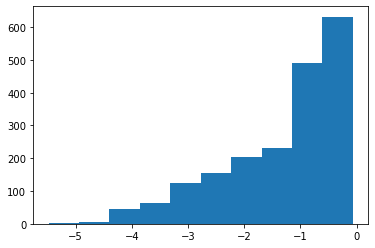

In [107]:
plt.hist(reg_df['EmployerConcentration'])

In [111]:
mod1 = smf.ols('SkillChange ~ LogSkillNAll', data=reg_df)
res1 = mod1.fit()

mod2= smf.ols('SkillChange ~ Education', data=reg_df)
res2 = mod2.fit()

mod3= smf.ols('SkillChange ~ LogPay', data=reg_df)
res3 = mod3.fit()

mod5= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df)
res5 = mod5.fit()

mod6= smf.ols('SkillChange ~ Education + EmployerConcentration', data=reg_df)
res6 = mod6.fit()

mod7= smf.ols('SkillChange ~ LogPay + EmployerConcentration', data=reg_df)
res7 = mod7.fit()

stargazer = Stargazer([res1, res3, res2, res5, res7, res6])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity')
stargazer.custom_columns(['Model 1', 'Model 2', 'Model 3', 'Model 4', 'Model 5', 'Model 6'], [1, 1, 1, 1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillNAll', 'LogPay', 'Education', 'EmployerConcentration'])

stargazer.rename_covariates({'LogSkillNAll': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education', 'EmployerConcentration': 'Log Emp. Concentr.'})
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
stargazer

In [112]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Skill Complexity}
\begin{tabular}{@{\extracolsep{5pt}}lcccccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{6}{c}{\textit{Dependent variable:}} \
\cr \cline{6-7}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2} & \multicolumn{1}{c}{Model 3} & \multicolumn{1}{c}{Model 4} & \multicolumn{1}{c}{Model 5} & \multicolumn{1}{c}{Model 6}  \\
\hline \\[-1.8ex]
 Skill Complexity & -0.048$^{***}$ & & & -0.042$^{***}$ & & \\
  & (0.002) & & & (0.002) & & \\
 Log Annual Pay & & -0.030$^{***}$ & & & -0.026$^{***}$ & \\
  & & (0.004) & & & (0.003) & \\
 Education & & & -0.005$^{***}$ & & & -0.005$^{***}$ \\
  & & & (0.001) & & & (0.001) \\
 Log Emp. Concentr. & & & & 0.009$^{***}$ & 0.024$^{***}$ & 0.024$^{***}$ \\
  & & & & (0.001) & (0.001) & (0.001) \\
\hline \\[-1.8ex]
 Observations & 1,952 & 1,952 & 1,952 & 1,952 & 1,952 & 1,952 \\
 $R^2$ & 0.338 & 0.034 & 0.027 & 0.354 & 0.191 & 0.192

In [113]:
print(stargazer.render_html())

Explaining Job Skill Change Variation with Skill Complexity<br><table style="text-align:center"><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="6"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Model 1</td><td colspan="1">Model 2</td><td colspan="1">Model 3</td><td colspan="1">Model 4</td><td colspan="1">Model 5</td><td colspan="1">Model 6</td></tr><tr><td colspan="7" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Complexity</td><td>-0.048<sup>***</sup></td><td></td><td></td><td>-0.042<sup>***</sup></td><td></td><td></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td><td></td><td></td><td>(0.002)</td><td></td><td></td></tr><tr><td style="text-align:left">Log Annual Pay</td><td></td><td>-0.030<sup>***</sup></td><td></td><td></td><td>-0.026<sup>***</sup></td><td></td></tr><tr><td style="text-align:lef

In [138]:
resf1 =  smf.ols("SkillChange ~ LargeEmployer + C(Occupation)", data=reg_df).fit()
resf2 =  smf.ols("SkillChange ~ LargeMarket + C(Occupation)", data=reg_df).fit()
resf3 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + C(Occupation)+ EmployerConcentration", data=reg_df).fit()

stargazerf = Stargazer([resf1, resf2, resf3])

stargazerf.title('Explaining Job Skill Change Variation with Employer and Market size')
stargazerf.custom_columns(['Model 1', 'Model 2', 'Model 3'], [1, 1, 1])
stargazerf.show_model_numbers(False)
stargazerf.covariate_order(['LargeEmployer[T.1]', 'LargeMarket[T.1]','EmployerConcentration'])
stargazerf.rename_covariates({'LargeEmployer[T.1]': 'Large Employer', 'LargeMarket[T.1]': 'Large Market', 
                             'EmployerConcentration': 'Log Emp. Concentr.'})
stargazerf.significance_levels([0.05, 0.01, 0.001])
stargazerf.add_line('Occ. FE', ['Yes', 'Yes', 'Yes'])
stargazerf.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
stargazerf

In [139]:
print(stargazerf.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Employer and Market size}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & \multicolumn{1}{c}{Model 1} & \multicolumn{1}{c}{Model 2} & \multicolumn{1}{c}{Model 3}  \\
\hline \\[-1.8ex]
 Large Employer & -0.024$^{***}$ & & -0.027$^{***}$ \\
  & (0.002) & & (0.002) \\
 Large Market & & -0.019$^{***}$ & -0.046$^{***}$ \\
  & & (0.002) & (0.004) \\
 Log Emp. Concentr. & & & -0.016$^{***}$ \\
  & & & (0.002) \\
 Occ. FE & Yes & Yes & Yes \\
\hline \\[-1.8ex]
 Observations & 1,952 & 1,952 & 1,952 \\
 $R^2$ & 0.730 & 0.719 & 0.763 \\
 Adjusted $R^2$ & 0.599 & 0.583 & 0.647 \\
 Residual Std. Error & 0.040(df = 1313) & 0.040(df = 1313) & 0.037(df = 1311)  \\
 F Statistic & 5.569$^{***}$ (df = 638.0; 1313.0) & 5.276$^{***}$ (df = 638.0; 1313.0) & 6.588$^{***}$ (df = 640.0; 1311.0) \\
\hline
\hline \\[-1

In [140]:
print(stargazerf.render_html())

Explaining Job Skill Change Variation with Employer and Market size<br><table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Model 1</td><td colspan="1">Model 2</td><td colspan="1">Model 3</td></tr><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Large Employer</td><td>-0.024<sup>***</sup></td><td></td><td>-0.027<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td><td></td><td>(0.002)</td></tr><tr><td style="text-align:left">Large Market</td><td></td><td>-0.019<sup>***</sup></td><td>-0.046<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td></td><td>(0.002)</td><td>(0.004)</td></tr><tr><td style="text-align:left">Log Emp. Concentr.</td><td></td><td></td><td>-0.016<sup>***</sup></td></tr>

### Extended Results: different job content scope with skill weights

In [117]:
# weights for each skill for each job
jysw=defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
for yr in yjas:
    for j in yjas[yr]:
        freqsum=np.sum(list(yjas[yr][j].values()))
        for s in yjas[yr][j]:
            jysw[j][yr][s] = yjas[yr][j][s] / freqsum        

In [118]:
# 200 dimension Job-Year-Vector
jyv_w = defaultdict(lambda:defaultdict(lambda:''))
for j in jysw:
    for y in jysw[j]:
        jyv_w[j][y] = np.sum([model.wv[s]*jysw[j][y][s] for s in jysw[j][y].keys() if s in model.wv],axis=0)

# job change from 2010 to 2018: 1 - dot product between 2 job vectors
jtr_w = {}
for j in jyv_w:
    if 2010 in jyv_w[j] and 2018 in jyv_w[j]:
        if j in jyn:
            # retain jobs with more than 100 posts in both 2010 and 2018
            if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                jtr_w[j] = 1- np.dot(jyv_w[j][2018], jyv_w[j][2010])/(
                    np.linalg.norm(jyv_w[j][2018])* np.linalg.norm(jyv_w[j][2010]))

jtr_w = dict(sorted(jtr_w.items(), key=operator.itemgetter(1)))

In [119]:
def weighted_change_coreskill(dictyjas, quant):
    
    # filter the defining skills
    jys2 = defaultdict(lambda:defaultdict(lambda:[]))
    yjas2 = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
    for year in dictyjas:
        for job in dictyjas[year]:
            threshold = np.quantile(list(dictyjas[year][job].values()), [quant])
            for skill in yjas[year][job]:
                if dictyjas[year][job][skill] >= threshold:
                    jys2[job][year].append(skill)
                    yjas2[year][job][skill]+= dictyjas[year][job][skill]
            if len(jys2[job][year]) < 5:
                #print(job, year)
                del jys2[job][year]

    jycsw = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:0)))
    for yr in yjas2:
        for j in yjas2[yr]:
            freqsum=np.sum(list(yjas2[yr][j].values()))
            for s in yjas2[yr][j]:
                jycsw[j][yr][s] = yjas2[yr][j][s] / freqsum   
                
    # 200 dimension Job-Year-Vector
    jyv_w2 = defaultdict(lambda:defaultdict(lambda:''))
    for j in jycsw:
        for y in jycsw[j]:
            jyv_w2[j][y] = np.sum([model.wv[s]*jycsw[j][y][s] for s in jycsw[j][y].keys() if s in model.wv],axis=0)

    # job change from 2010 to 2018: 1 - dot product between 2 job vectors
    jtr_w2 = {}
    for j in jyv_w2:
        if 2010 in jyv_w2[j] and 2018 in jyv_w2[j]:
            if j in jyn:
                # retain jobs with more than 100 posts in both 2010 and 2018
                if jyn[j][2010] > 100 and jyn[j][2018] > 100:
                    jtr_w2[j] = 1- np.dot(jyv_w2[j][2018], jyv_w2[j][2010])/(
                        np.linalg.norm(jyv_w2[j][2018])* np.linalg.norm(jyv_w2[j][2010]))

    jtr_w2 = dict(sorted(jtr_w2.items(), key=operator.itemgetter(1)))
    
    return jtr_w2

In [120]:
def reg_dataframe(lcllocjtrwa, lcslocjtrwa, scllocjtrwa, scslocjtrwa):
    # put variables in a dataframe
    reg_df2=pd.DataFrame(columns = ['Occupation','SkillChange', 'LogSkillN', 'LogSkillNAll', 'Education', 'LogPay', 'LargeEmployer', 'LargeMarket',
                                  'EmployerConcentration', 'LargeEmployer_LogSkillN', 'LargeMarket_LogSkillN',
                                   'LargeEmployer_LogSkillNAll', 'LargeMarket_LogSkillNAll',
                        'LargeEmployer_LogPay', 'LargeMarket_LogPay', 'LargeEmployer_Education', 'LargeMarket_Education'])

    for j in lcllocjtrwa:
        if j in lcllocosn and j in oe and j in op and j in Lloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange': lcllocjtrwa[j], 'LogSkillN': np.log(lcllocosn[j]),
                'LogSkillNAll': np.log(osn[j]),'Education': oe[j], 'LogPay': np.log(op[j]), 'LargeEmployer': 1, 
                                    'LargeMarket': 1,'EmployerConcentration': np.log(Lloc_OCCEC[j]), 
                    'LargeEmployer_LogSkillN': 1*np.log(lcllocosn[j]), 'LargeMarket_LogSkillN': 1*np.log(lcllocosn[j]),
                    'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),
                    'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                    'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)

    for j in  lcslocjtrwa:
        if j in lcslocosn and j in oe and j in op and j in Sloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange':  lcslocjtrwa[j], 'LogSkillN': np.log(lcslocosn[j]), 
                                    'LogSkillNAll': np.log(osn[j]), 'Education': oe[j], 'LogPay': np.log(op[j]), 
                                    'LargeEmployer': 1, 'LargeMarket': 0,'EmployerConcentration': np.log(Sloc_OCCEC[j]), 
                    'LargeEmployer_LogSkillN': 1*np.log(lcslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(lcslocosn[j]),
                    'LargeEmployer_LogSkillNAll': 1*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                    'LargeEmployer_LogPay':1*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                    'LargeEmployer_Education': 1*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)

    for j in scllocjtrwa:
        if j in scllocosn and j in oe and j in op and j in Lloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange':scllocjtrwa[j], 'LogSkillN': np.log(scllocosn[j]), 
                                    'LogSkillNAll': np.log(osn[j]),  'Education': oe[j], 'LogPay': np.log(op[j]), 
                                    'LargeEmployer': 0, 'LargeMarket': 1,'EmployerConcentration': np.log(Lloc_OCCEC[j]), 
                    'LargeEmployer_LogSkillN': 0*np.log(scllocosn[j]), 'LargeMarket_LogSkillN': 1*np.log(scllocosn[j]),
                    'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 1*np.log(osn[j]),
                    'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 1*np.log(op[j]), 
                    'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 1*oe[j]}, ignore_index = True)

    for j in scslocjtrwa:
        if j in scslocosn and j in oe and j in op and j in Sloc_OCCEC:
            reg_df2=reg_df2.append({'Occupation': j, 'SkillChange': scslocjtrwa[j], 'LogSkillN': np.log(scslocosn[j]), 
                                    'LogSkillNAll': np.log(osn[j]), 'Education': oe[j], 'LogPay': np.log(op[j]),
                                    'LargeEmployer': 0, 'LargeMarket': 0,'EmployerConcentration': np.log(Sloc_OCCEC[j]), 
                    'LargeEmployer_LogSkillN': 0*np.log(scslocosn[j]), 'LargeMarket_LogSkillN': 0*np.log(scslocosn[j]),
                    'LargeEmployer_LogSkillNAll': 0*np.log(osn[j]), 'LargeMarket_LogSkillNAll': 0*np.log(osn[j]),
                    'LargeEmployer_LogPay':0*np.log(op[j]), 'LargeMarket_LogPay': 0*np.log(op[j]), 
                    'LargeEmployer_Education': 0*oe[j], 'LargeMarket_Education': 0*oe[j]}, ignore_index = True)
            
    return reg_df2

In [121]:
lcllocjtrwa = weighted_change_coreskill(lcllocyjas, 0)
lcslocjtrwa = weighted_change_coreskill(lcslocyjas, 0)
scllocjtrwa = weighted_change_coreskill(scllocyjas, 0)
scslocjtrwa = weighted_change_coreskill(scslocyjas, 0)
reg_df_was = reg_dataframe(lcllocjtrwa, lcslocjtrwa, scllocjtrwa, scslocjtrwa)

In [122]:
lcllocjtrw50 = weighted_change_coreskill(lcllocyjas, 0.5)
lcslocjtrw50 = weighted_change_coreskill(lcslocyjas,  0.5)
scllocjtrw50 = weighted_change_coreskill(scllocyjas,  0.5)
scslocjtrw50 = weighted_change_coreskill(scslocyjas,  0.5)
reg_df_w50 = reg_dataframe(lcllocjtrw50, lcslocjtrw50, scllocjtrw50, scslocjtrw50)

In [123]:
lcllocjtrw75 = weighted_change_coreskill(lcllocyjas, 0.75)
lcslocjtrw75 = weighted_change_coreskill(lcslocyjas,  0.75)
scllocjtrw75 = weighted_change_coreskill(scllocyjas,  0.75)
scslocjtrw75 = weighted_change_coreskill(scslocyjas,  0.75)
reg_df_w75 = reg_dataframe(lcllocjtrw75, lcslocjtrw75, scllocjtrw75, scslocjtrw75)

In [130]:
mod5= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df_was)
res5 = mod5.fit()

mod6= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df_w50)
res6 = mod6.fit()

mod7= smf.ols('SkillChange ~ LogSkillNAll + EmployerConcentration', data=reg_df_w75)
res7 = mod7.fit()

stargazer = Stargazer([res5, res6, res7])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity, Different Job Content Scope and Skill Weights')
stargazer.custom_columns(['All Skills', 'Top 50\% Skills', 'Top 75\% Skills'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillNAll', 'EmployerConcentration'])

stargazer.rename_covariates({'LogSkillNAll': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education', 'EmployerConcentration': 'Log Emp. Concentr.'})
stargazer.significance_levels([0.05, 0.01, 0.001])
stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
stargazer

In [131]:
print(stargazer.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Skill Complexity, Different Job Content Scope and Skill Weights}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & \multicolumn{1}{c}{All Skills} & \multicolumn{1}{c}{Top 50\% Skills} & \multicolumn{1}{c}{Top 75\% Skills}  \\
\hline \\[-1.8ex]
 Skill Complexity & -0.023$^{***}$ & -0.023$^{***}$ & -0.024$^{***}$ \\
  & (0.001) & (0.001) & (0.001) \\
 Log Emp. Concentr. & 0.003$^{**}$ & 0.003$^{**}$ & 0.003$^{**}$ \\
  & (0.001) & (0.001) & (0.001) \\
\hline \\[-1.8ex]
 Observations & 2,551 & 2,551 & 2,551 \\
 $R^2$ & 0.218 & 0.218 & 0.223 \\
 Adjusted $R^2$ & 0.217 & 0.217 & 0.222 \\
 Residual Std. Error & 0.042(df = 2548) & 0.042(df = 2548) & 0.043(df = 2548)  \\
 F Statistic & 354.181$^{***}$ (df = 2.0; 2548.0) & 354.534$^{***}$ (df = 2.0; 2548.0) & 365.124$^{***}$ (df = 2.0; 2548.0) \\
\hline

In [132]:
print(stargazer.render_html())

Explaining Job Skill Change Variation with Skill Complexity, Different Job Content Scope and Skill Weights<br><table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">All Skills</td><td colspan="1">Top 50\% Skills</td><td colspan="1">Top 75\% Skills</td></tr><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Complexity</td><td>-0.023<sup>***</sup></td><td>-0.023<sup>***</sup></td><td>-0.024<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.001)</td><td>(0.001)</td><td>(0.001)</td></tr><tr><td style="text-align:left">Log Emp. Concentr.</td><td>0.003<sup>**</sup></td><td>0.003<sup>**</sup></td><td>0.003<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.001)</td><td>(0.001)</td><td>(0.001)</t

In [133]:
resfrc1 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + C(Occupation)+ EmployerConcentration", 
                 data=reg_df_was).fit()
resfrc2 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + C(Occupation)+ EmployerConcentration", 
                 data=reg_df_w50).fit()
resfrc3 =  smf.ols("SkillChange ~ LargeEmployer + LargeMarket + C(Occupation)+ EmployerConcentration", 
                 data=reg_df_w75).fit()

stargazer_rc = Stargazer([resfrc1, resfrc2, resfrc3])

stargazer_rc.title('Explaining Job Skill Change Variation with Organization and Local Market Size, Different Job Content Scope and Skill Weights')
stargazer_rc.custom_columns(['All Skills', 'Top 50\% Skills', 'Top 75\% Skills'], [1, 1, 1])
stargazer_rc.show_model_numbers(False)
stargazer_rc.covariate_order(['LargeEmployer[T.1]', 'LargeMarket[T.1]', 
                            'EmployerConcentration'])
stargazer_rc.rename_covariates({'LargeEmployer[T.1]': 'Large Employer', 'LargeMarket[T.1]': 'Large Market', 
   'EmployerConcentration': 'Log Emp. Concentr.'})
stargazer_rc.significance_levels([0.05, 0.01, 0.001])
stargazer_rc.add_line('Occ. FE', ['Yes', 'Yes', 'Yes'])
stargazer_rc.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
stargazer_rc

In [134]:
print(stargazer_rc.render_latex())

\begin{table}[!htbp] \centering
  \caption{Explaining Job Skill Change Variation with Organization and Local Market Size, Different Job Content Scope and Skill Weights}
\begin{tabular}{@{\extracolsep{5pt}}lccc}
\\[-1.8ex]\hline
\hline \\[-1.8ex]
& \multicolumn{3}{c}{\textit{Dependent variable:}} \
\cr \cline{3-4}
\\[-1.8ex] & \multicolumn{1}{c}{All Skills} & \multicolumn{1}{c}{Top 50\% Skills} & \multicolumn{1}{c}{Top 75\% Skills}  \\
\hline \\[-1.8ex]
 Large Employer & -0.006$^{***}$ & -0.006$^{***}$ & -0.005$^{***}$ \\
  & (0.001) & (0.001) & (0.001) \\
 Large Market & -0.009$^{***}$ & -0.009$^{***}$ & -0.007$^{**}$ \\
  & (0.003) & (0.003) & (0.003) \\
 Log Emp. Concentr. & -0.002$^{}$ & -0.002$^{}$ & -0.001$^{}$ \\
  & (0.002) & (0.002) & (0.002) \\
 Occ. FE & Yes & Yes & Yes \\
\hline \\[-1.8ex]
 Observations & 2,551 & 2,551 & 2,551 \\
 $R^2$ & 0.692 & 0.692 & 0.701 \\
 Adjusted $R^2$ & 0.568 & 0.569 & 0.581 \\
 Residual Std. Error & 0.031(df = 1819) & 0.031(df = 1819) & 0.032(df 

In [136]:
print(stargazer_rc.render_html())

Explaining Job Skill Change Variation with Organization and Local Market Size, Different Job Content Scope and Skill Weights<br><table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">All Skills</td><td colspan="1">Top 50\% Skills</td><td colspan="1">Top 75\% Skills</td></tr><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Large Employer</td><td>-0.006<sup>***</sup></td><td>-0.006<sup>***</sup></td><td>-0.005<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.001)</td><td>(0.001)</td><td>(0.001)</td></tr><tr><td style="text-align:left">Large Market</td><td>-0.009<sup>***</sup></td><td>-0.009<sup>***</sup></td><td>-0.007<sup>**</sup></td></tr><tr><td style="text-align:left"></td><td>(0.003)</td><td>(0.003)</td

### Most Significant Skill Transition as Skill Change

In [181]:
lcllocjtrm0 = JobChange(lcllocjys, "max", 0)
lcslocjtrm0 = JobChange(lcslocjys, "max", 0)
scllocjtrm0 = JobChange(scllocjys, "max", 0)
scslocjtrm0 = JobChange(scslocjys, "max", 0)
reg_df_max0 = reg_dataframe(lcllocjtrm0, lcslocjtrm0, scllocjtrm0, scslocjtrm0)

781

In [177]:
lcllocjtrm5 = JobChange(lcllocjys, "max", 0.05)
lcslocjtrm5 = JobChange(lcslocjys, "max", 0.05)
scllocjtrm5 = JobChange(scllocjys, "max", 0.05)
scslocjtrm5 = JobChange(scslocjys, "max", 0.05)
reg_df_max5 = reg_dataframe(lcllocjtrm5, lcslocjtrm5, scllocjtrm5, scslocjtrm5)

781

In [178]:
lcllocjtrm10 = JobChange(lcllocjys, "max", 0.1)
lcslocjtrm10 = JobChange(lcslocjys, "max", 0.1)
scllocjtrm10 = JobChange(scllocjys, "max", 0.1)
scslocjtrm10 = JobChange(scslocjys, "max", 0.1)
reg_df_max10 = reg_dataframe(lcllocjtrm10, lcslocjtrm10, scllocjtrm10, scslocjtrm10)

781

In [184]:
mod5= smf.ols('SkillChange ~ LogSkillNAll + Education + LogPay', data=reg_df_max0)
res5 = mod5.fit()

mod6= smf.ols('SkillChange ~ LogSkillNAll + Education + LogPay', data=reg_df_max5)
res6 = mod6.fit()

mod7= smf.ols('SkillChange ~ LogSkillNAll + Education + LogPay', data=reg_df_max10)
res7 = mod7.fit()

stargazer = Stargazer([res5, res6, res7])

stargazer.title('Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change')
stargazer.custom_columns(['Max Skill Transition', 'Rank 5\% Max Skill Transition', 'Rank 10\% Max Skill Transition'], [1, 1, 1])
stargazer.show_model_numbers(False)
stargazer.covariate_order(['LogSkillNAll',  'LogPay', 'Education'])

stargazer.rename_covariates({'LogSkillNAll': 'Skill Complexity', 'LogPay': 'Log Annual Pay', 
    'Education': 'Education'})
stargazer.significance_levels([0.05, 0.01, 0.001])
#stargazer.add_custom_notes(['Log Emp. Concentr. refers to the natural log of HHI (employer concentration).'])
stargazer

In [185]:
print(stargazer.render_html())

Explaining Job Skill Change Variation with Skill Complexity, Different Measures of Change<br><table style="text-align:center"><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left"></td><td colspan="3"><em>Dependent variable:SkillChange</em></td></tr><tr><td style="text-align:left"></td><tr><td></td><td colspan="1">Max Skill Transition</td><td colspan="1">Rank 5\% Max Skill Transition</td><td colspan="1">Rank 10\% Max Skill Transition</td></tr><tr><td colspan="4" style="border-bottom: 1px solid black"></td></tr><tr><td style="text-align:left">Skill Complexity</td><td>-0.015<sup>***</sup></td><td>-0.048<sup>***</sup></td><td>-0.056<sup>***</sup></td></tr><tr><td style="text-align:left"></td><td>(0.002)</td><td>(0.002)</td><td>(0.002)</td></tr><tr><td style="text-align:left">Log Annual Pay</td><td>-0.017<sup>*</sup></td><td>-0.014<sup>*</sup></td><td>-0.015<sup>*</sup></td></tr><tr><td style="text-align:left"></td><td>(0.007)</td><td>(0.006)<